# Self-Driving Car Engineer Nanodegree

In [1]:
#importing some useful packagesh
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
import numpy as np
from sklearn.mixture.gaussian_mixture import GaussianMixture
import cv2
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


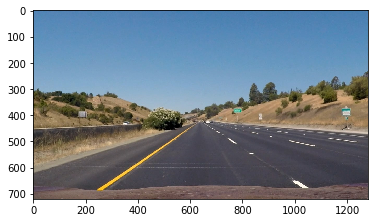

In [2]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

OUTPUT_DIR = 'output_images/'

def draw_road(img, left_y, left_x, right_y, right_x):
    # Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

    # Plots the left and right polynomials on the lane lines
    left_curvature = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_curvature = np.array([np.transpose(np.vstack([right_fitx[::-1], ploty[::-1]]))])
    road = np.hstack((left_curvature, right_curvature))
    
    cv2.fillPoly(img, np.int_([road]), (255, 0, 0))
    return img

def r_curve(y, fit):
    A, B, C = fit
    return np.power(1 + np.power(2 * A * y+ B, 2), 3/2) / np.absolute( 2 * A)

def get_lanes_cloud(binary):
    window_centroids = find_window_centroids(
        binary, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) == 0:
        raise 'No centroids found'
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    
    # Go through each level and draw the windows
    for level in range(0, len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width, window_height,
                            binary, window_centroids[level][0], level)
        r_mask = window_mask(window_width, window_height,
                            binary, window_centroids[level][1], level)
        # Add graphic points from window mask here to total pixels found
        #l_points[(binary == 255) & ((l_mask == 1))] = 255
        #r_points[(binary == 255) & ((r_mask == 1))] = 255

        y, x = np.nonzero((binary > 0) & ((l_mask == 1)))
        left_x.append(x)
        left_y.append(y)
        y, x = np.nonzero((binary > 0) & ((r_mask == 1)))
        right_x.append(x)
        right_y.append(y)

    left_x = np.concatenate(left_x)
    left_y = np.concatenate(left_y)
    right_x = np.concatenate(right_x)
    right_y = np.concatenate(right_y)
    return ((left_x, left_y), (right_x, right_y))

def find_window_centroids(image, window_width, window_height, margin):
    # Store the (left,right) window centroid positions per level
    window_centroids = []
    # Create our window template that we will use for convolutions
    window = np.ones(window_width)

    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3 * image.shape[0] / 4):,
                   :int(image.shape[1] / 2)], axis=0)
    l_center = np.argmax(np.convolve(window, l_sum)) - window_width / 2
    r_sum = np.sum(image[int(3 * image.shape[0] / 4):,
                   int(image.shape[1] / 2):], axis=0)
    r_center = np.argmax(np.convolve(window, r_sum)) - \
                         window_width / 2 + int(image.shape[1] / 2)

    # Add what we found for the first layer
    window_centroids.append((l_center, r_center))

    # Go through each layer looking for max pixel locations
    for level in range(1, (int)(image.shape[0] / window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0] - (level + 1) * window_height)
                             :int(image.shape[0] - level * window_height), :], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width / 2
        l_min_index = int(max(l_center + offset - margin, 0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        conv = conv_signal[l_min_index:l_max_index]
        if np.any(conv):
            l_center = np.argmax(conv)+l_min_index-offset
        #else:
            #print("empty conv on {} level".format(level))
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        conv = conv_signal[r_min_index:r_max_index]
        if np.any(conv):
            r_center = np.argmax(conv)+r_min_index-offset
        #else:
            #print("empty conv on {} level".format(level))
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


        def threshold(img, s_thresh=(150, 255), l_thresh=(150, 255), sx_thresh=(20, 100), mag_thresh=(30, 100), sobel_kernel=31):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    # Threshold color channel
    hls_s_binary = np.zeros_like(s_channel)
    hls_s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    hls_l_binary = np.zeros_like(l_channel)
    hls_l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    binary =  hls_s_binary | hls_l_binary
    
    # Sobel
    retouched = np.dstack(( np.zeros_like(l_channel), l_channel, s_channel))
    gray = cv2.cvtColor(retouched, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel = np.dstack((sobelx, sobely))
    magnitude = np.linalg.norm(sobel, axis=2)
    scaled_sobel = np.uint8(255*magnitude/np.max(magnitude))
    # Create a binary mask where mag thresholds are met
    sobel_mag_binary = np.zeros_like(scaled_sobel)
    sobel_mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1]) & (
        scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # Sobel on x  to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx)
    scaled_x_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold color channel
    sobel_x_binary = np.zeros_like(s_channel)
    sobel_x_binary[(scaled_x_sobel >= sx_thresh[0]) & (scaled_x_sobel <= sx_thresh[1])] = 1
    
    #plot_figures({'s': hls_s_binary, 'l': hls_l_binary, 'r': retouched, 'mag': sobel_mag_binary,'x': sobel_x_binary}, 1, 5)
    
    return binary & sobel_mag_binary & sobel_x_binary
    return binary & sobel_mag_binary

# Python 3 has support for cool math symbols.


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


def plot_figures(figures, nrows=1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    f, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 20))
    for ind, title in enumerate(figures):
        img = figures[title]
        axeslist.ravel()[ind].imshow(img, cmap='gray')
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout()

## Distortion Calibration

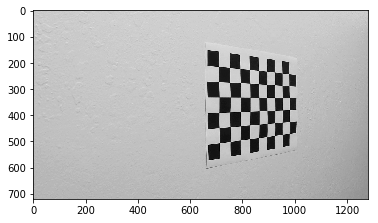

In [4]:
# prepare object points
CALLIBR_DIR = 'camera_cal/' 
nx = 9
ny = 6
imagePoints = []
objectPoints = []

for fname in os.listdir(CALLIBR_DIR):
    img = cv2.imread(CALLIBR_DIR + fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap='Greys_r')

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, use for calibration
    if ret:
        imagePoints.append(corners)
        # Find the chessboard corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

        objp = np.zeros((nx * ny, 3), np.float32)
        objp[:, :2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)
        objectPoints.append(objp)

    # Finally calibrate
if imagePoints and objectPoints:
    _, mtx, dist, *_ = cv2.calibrateCamera(objectPoints, imagePoints, (img.shape[1], img.shape[0]), None, None)
else:
    raise Exception("no chessboard was found on any image")

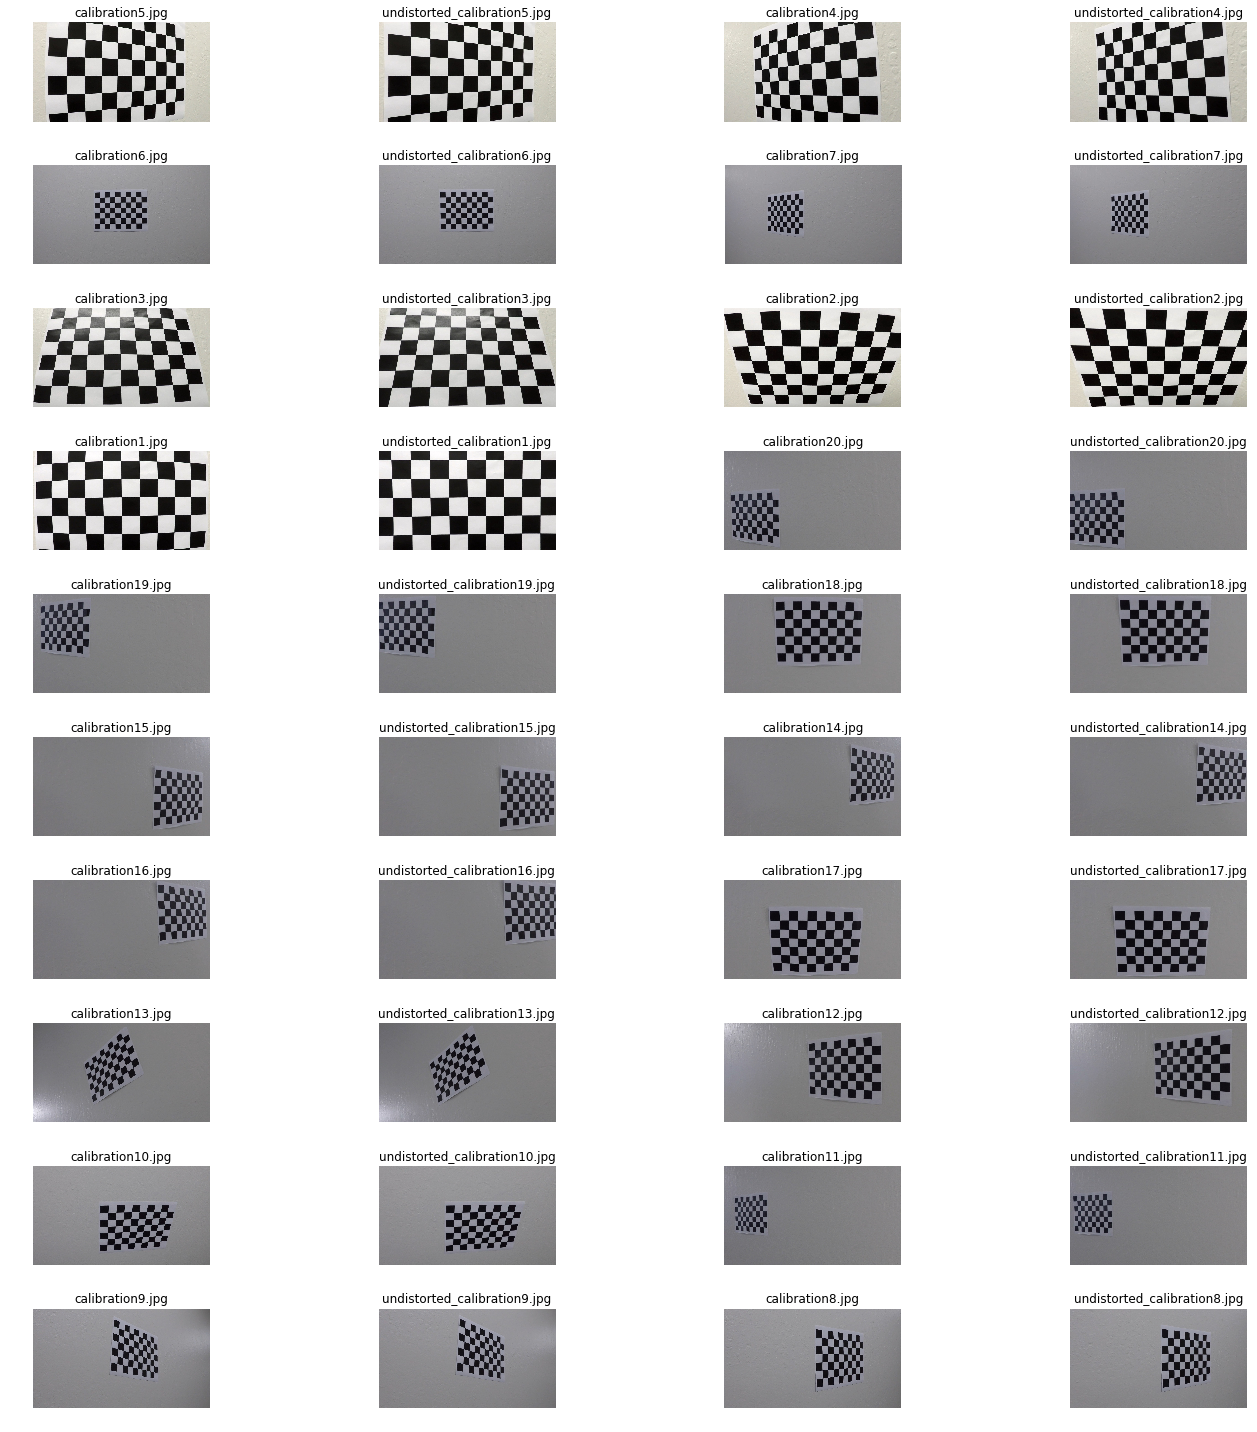

In [5]:
images = {}
for fname in os.listdir(CALLIBR_DIR):
    images[fname] = mpimg.imread(CALLIBR_DIR + fname)
    images['undistorted_' + fname] = cv2.undistort(
        mpimg.imread(CALLIBR_DIR + fname), mtx, dist, None, mtx)
    mpimg.imsave(OUTPUT_DIR + 'undistorted_' + fname, images['undistorted_' + fname])
plot_figures(images, 10, 4)

## Create thresholded binary image

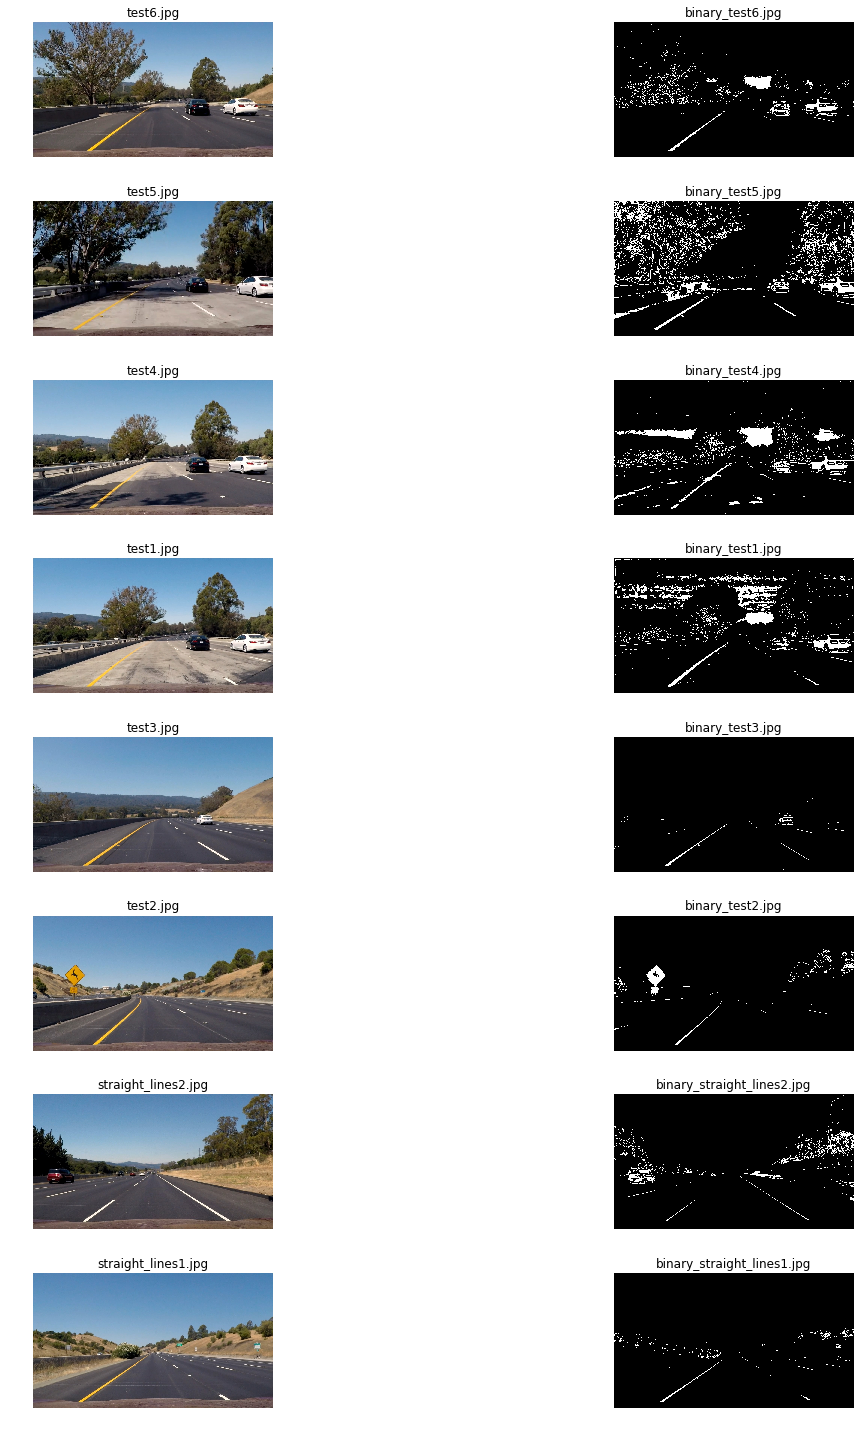

In [6]:
TST_DIR = 'test_images/'

images = {}
for fname in os.listdir(TST_DIR):
    img = mpimg.imread(TST_DIR + fname)
    images[fname] = img
    images['binary_' + fname] = threshold(img, s_thresh=(130, 255), l_thresh=(200, 255), sx_thresh=(0, 100), mag_thresh=(0, 100))
    #mpimg.imsave(OUTPUT_DIR + 'binary_' + fname, images['binary_' + fname])
plot_figures(images, 8, 2)

## Perspective transform Calibration

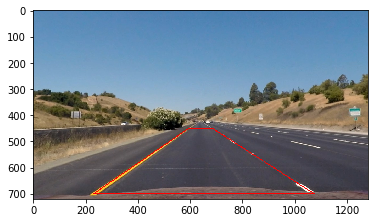

In [7]:
PERSPECTIVE_FILES = ['straight_lines1.jpg', 'straight_lines2.jpg']
img = cv2.undistort(mpimg.imread(TST_DIR + PERSPECTIVE_FILES[0]), mtx, dist, None, mtx)
src = np.int32([[595, 450], [230, 700], [1075, 700],
                [685, 450]]).reshape(-1, 1, 2)
cv2.polylines(img, [src], True, (255, 0, 0), 2)
print()
plt.imshow(img)
plt.imshow(img)

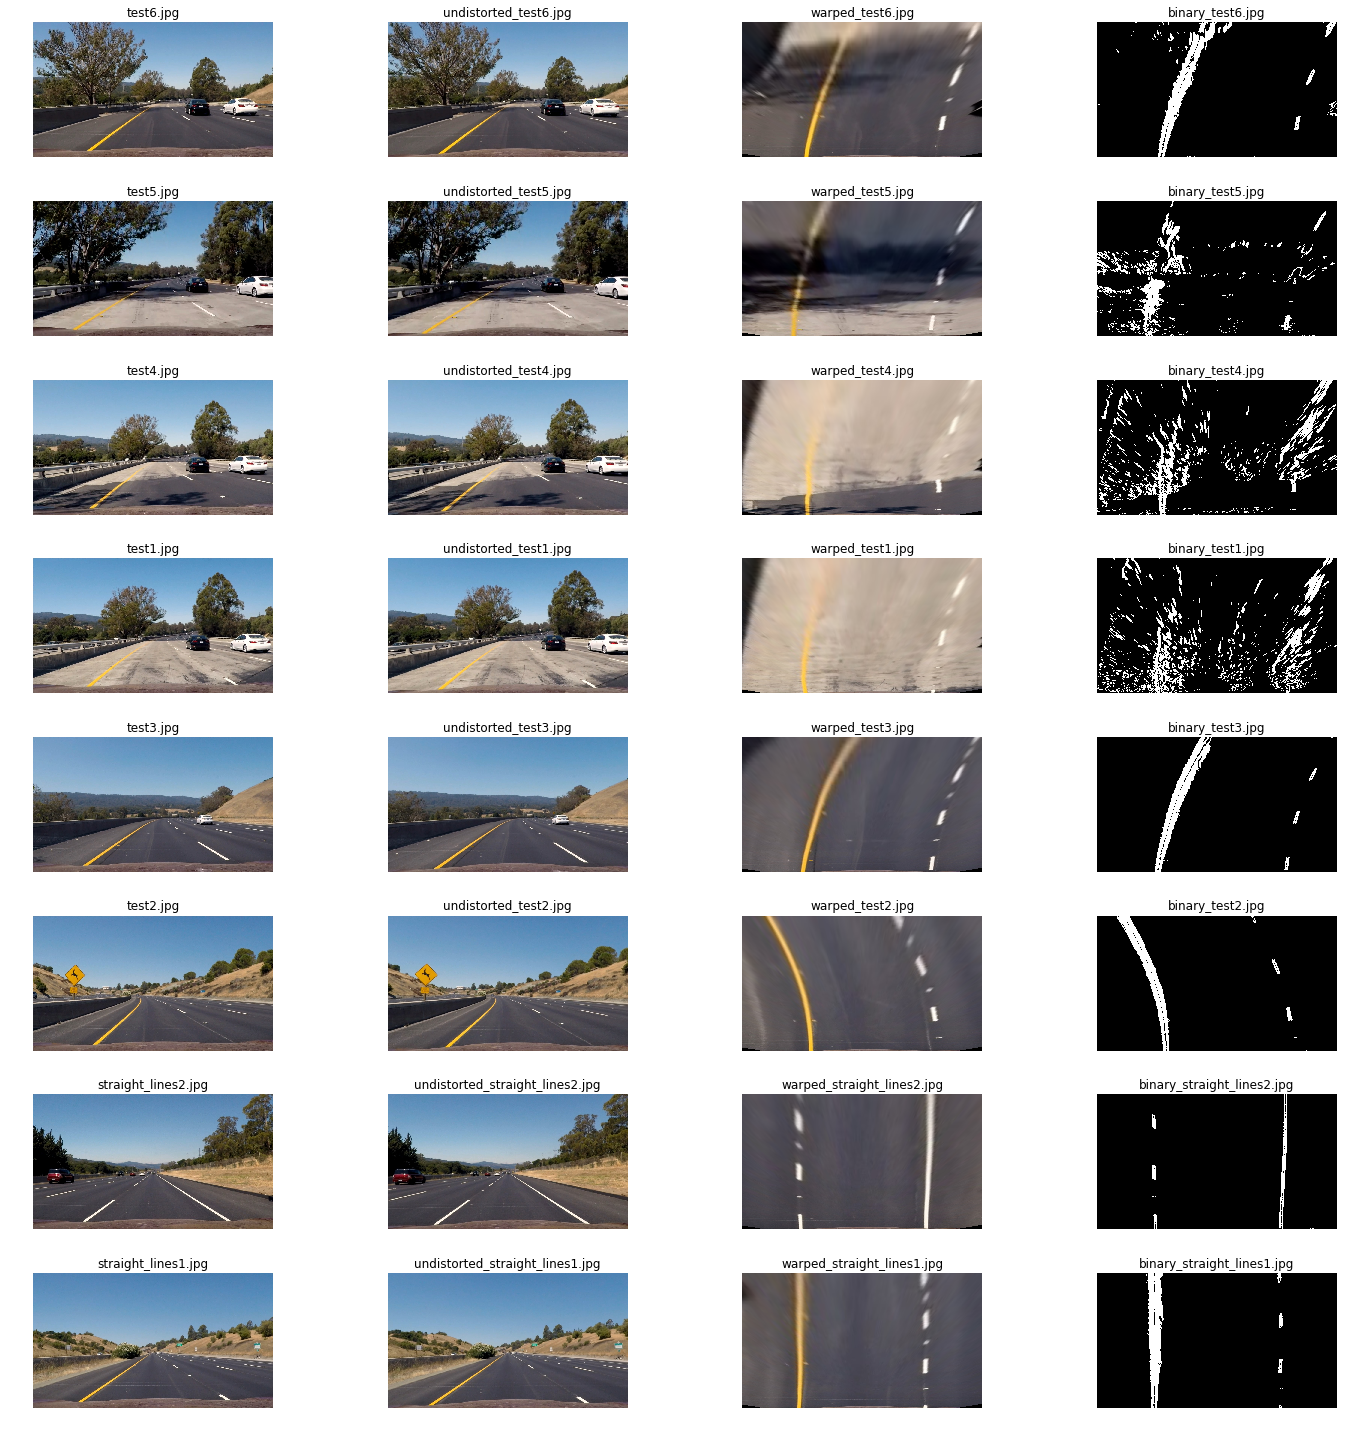

In [8]:
h, w = img.shape[0:2]
x_offset = 300
y_offset = 0
dst = np.float32([[0 + x_offset, 0 + y_offset], [0 + x_offset, h - y_offset],
                  [w - x_offset, h - y_offset], [w - x_offset, 0 + y_offset]])
M = cv2.getPerspectiveTransform(np.float32(src), dst)
invM = cv2.getPerspectiveTransform(dst, np.float32(src))
images = {}
for fname in os.listdir(TST_DIR):
    img = mpimg.imread(TST_DIR + fname)
    images[fname] = img
    images['undistorted_' + fname] = cv2.undistort(img, mtx, dist, None, mtx)
    images['warped_' + fname] = cv2.warpPerspective(images['undistorted_' + fname], M, (w, h), flags=cv2.INTER_LINEAR)
    images['binary_' + fname] = threshold(images['warped_' + fname], s_thresh=(
        45, 255), l_thresh=(200, 255), sx_thresh=(5, 255), mag_thresh=(5, 255), sobel_kernel=25)
    mpimg.imsave(OUTPUT_DIR + 'undistorted_' + fname, images['undistorted_' + fname])
    mpimg.imsave(OUTPUT_DIR + 'warped_' + fname, images['warped_' + fname])
    mpimg.imsave(OUTPUT_DIR + 'binary_' + fname, images['binary_' + fname], cmap=cm.gray)

plot_figures(images, 8, 4)

##  Identify lane-line pixels

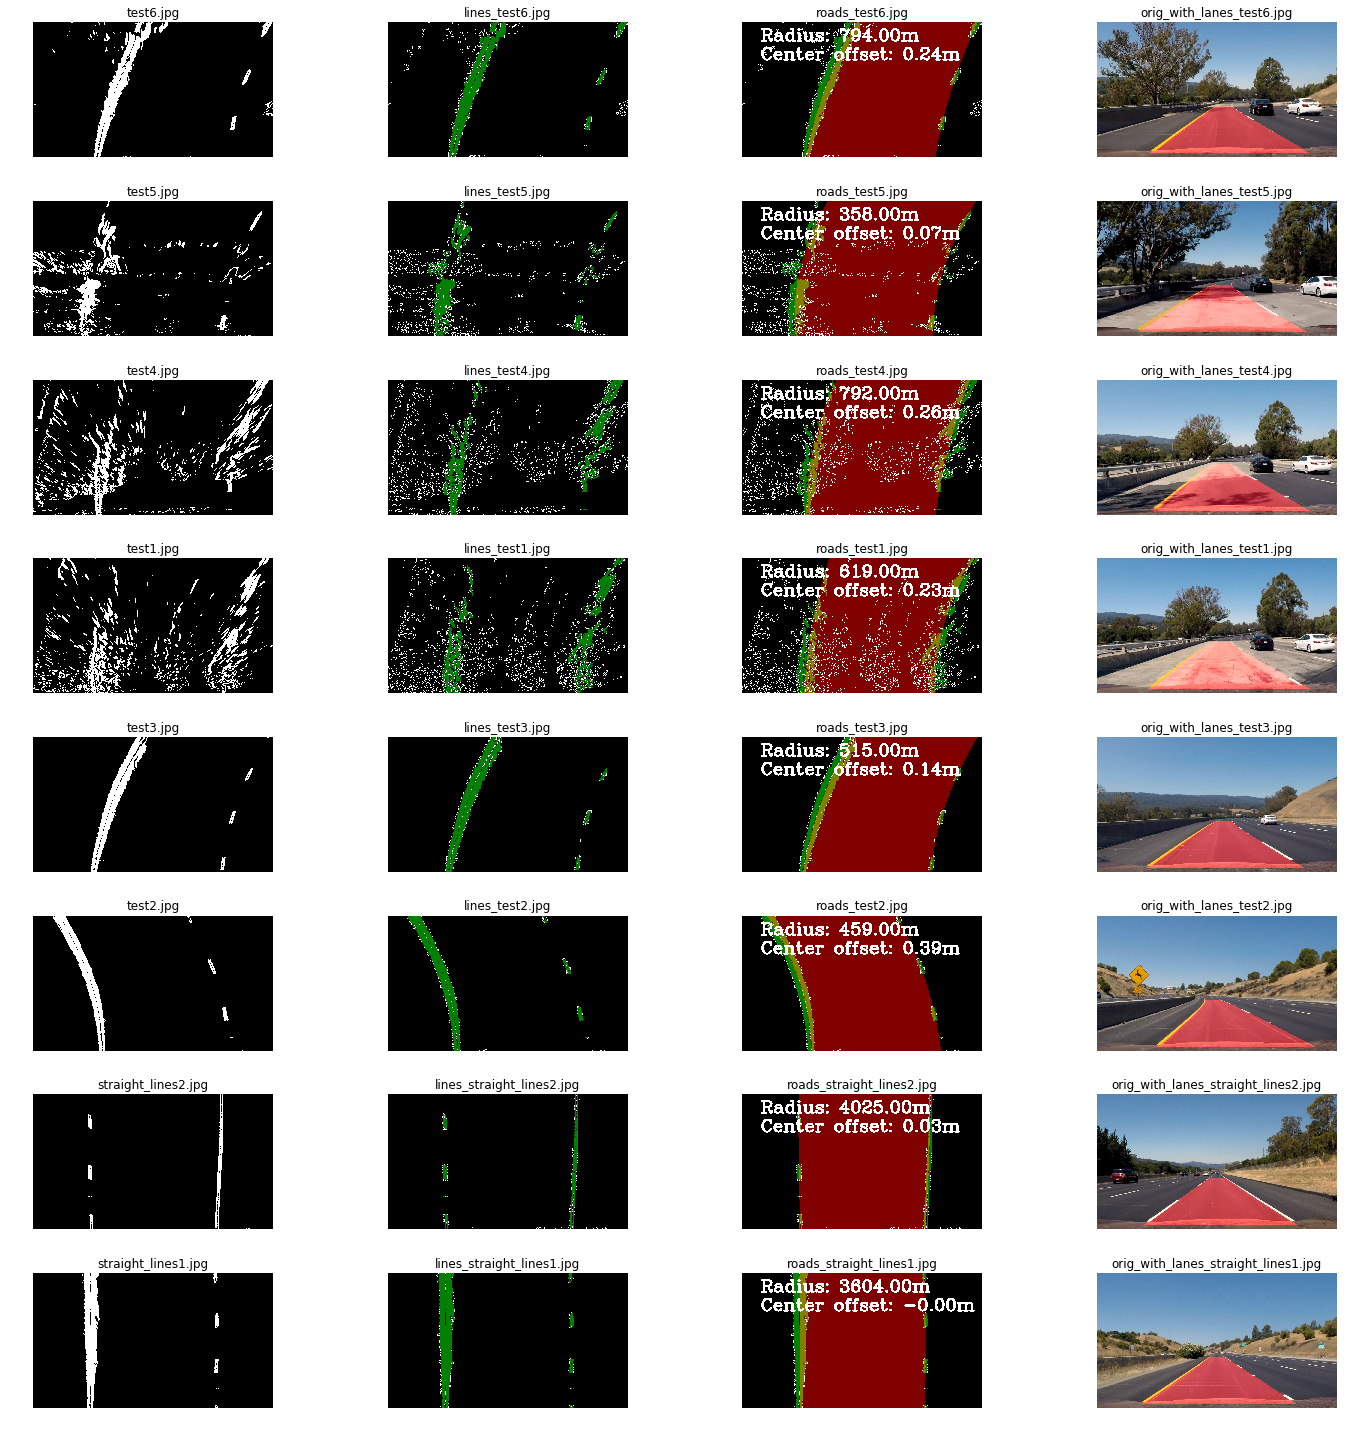

In [15]:
# Read in a thresholded image
# window settings
window_width = 100
window_height = 80  # Break image into 9 vertical layers since image height is 720
margin = 80  # How much to slide left and right for searching
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30 / 720  # meters per pixel in y dimension
xm_per_pix = 3.7 / 700  # meters per pixel in x dimension    

images = {}
for fname in os.listdir(TST_DIR):
    binary = mpimg.imread(OUTPUT_DIR + 'binary_' + fname)[:, :, 0]
    ((left_x, left_y), (right_x, right_y)) = get_lanes_cloud(binary)
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(binary)
    r_points = np.zeros_like(binary)
    l_points[(left_y, left_x)] = 255
    r_points[(right_y, right_x)] = 255

    y_eval = img.shape[0] * ym_per_pix

    # Implement the calculation of R_curve (radius of curvature) #####
    left_fit_cr = np.polyfit(left_y * ym_per_pix, left_x * xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_y * ym_per_pix, right_x * xm_per_pix, 2)
    left_curverad = r_curve(y_eval, left_fit_cr)
    right_curverad = r_curve(y_eval, right_fit_cr)

    # position of the vehicle with respect to center.
    left_lane_x = left_fit_cr[0] * y_eval**2 + left_fit_cr[1] * y_eval + left_fit_cr[2]
    right_lane_x = right_fit_cr[0] * y_eval**2 + right_fit_cr[1] * y_eval + right_fit_cr[2]
    lane_mid = (left_lane_x + right_lane_x - binary.shape[1] * xm_per_pix) / 2

    # Draw the results
    # add both left and right window pixels together
    template = np.array(r_points + l_points, np.uint8)
    zero_channel = np.zeros_like(template)  # create a zero color channel
    # make window pixels green
    template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8)
    # making the original road pixels 3 color channels
    warpage = np.dstack((binary, binary, binary)) * 255
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)  # overlay the orignal
    images[fname] = binary
    images['lines_' + fname] = output
    mpimg.imsave(OUTPUT_DIR + 'lines_' + fname, images['lines_' + fname])

    line_img = draw_road(np.zeros_like(output), left_y, left_x, right_y, right_x) 
    road_img = cv2.addWeighted(
        output, 1, line_img, 0.5, 0.0)  # overlay the orignal
    cv2.putText(road_img, "Radius: {:.2f}m".format(
        (left_curverad + right_curverad) // 2), (100, 100), cv2.FONT_HERSHEY_COMPLEX, 3, (255, 255, 255), 10)
    cv2.putText(road_img, "Center offset: {:.2f}m".format(
        lane_mid), (100, 200), cv2.FONT_HERSHEY_COMPLEX, 3, (255, 255, 255), 10)
    images['roads_' + fname] = road_img
    mpimg.imsave(OUTPUT_DIR + 'roads_' + fname, images['roads_' + fname])

    
    warped_line_img = cv2.warpPerspective(line_img, invM, (w, h), flags=cv2.INTER_LINEAR)
    orig_img = mpimg.imread(TST_DIR + fname)
    orig_img_with_lanes  = cv2.addWeighted(orig_img, 1, warped_line_img, 0.5, 0.0)  # overlay the orignal
    images['orig_with_lanes_' + fname] = orig_img_with_lanes
    mpimg.imsave(OUTPUT_DIR + 'orig_with_lanes_' + fname, images['orig_with_lanes_' + fname])


plot_figures(images, 8, 4)

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
def process_image(img):
    img = img
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(undist, M, (w, h), flags=cv2.INTER_LINEAR)
    binary = threshold(warped, s_thresh=(45, 255), l_thresh=(
        200, 255), sx_thresh=(5, 255), mag_thresh=(5, 255), sobel_kernel=25)
    ((left_x, left_y), (right_x, right_y)) = get_lanes_cloud(binary)
        
    line_img = draw_road(np.zeros_like(img), left_y, left_x, right_y, right_x)
    warped_line_img = cv2.warpPerspective(line_img, invM, (w, h), flags=cv2.INTER_LINEAR)
    # overlay the orignal
    dist_warped_lane_img = cv2.undistort(warped_line_img, mtx, -1 * dist, None, mtx)
    img = cv2.addWeighted(img, 1, dist_warped_lane_img, 1, 0.0)

    y_eval = img.shape[0] * ym_per_pix

    # Implement the calculation of R_curve (radius of curvature) #####
    left_fit_cr = np.polyfit(left_y * ym_per_pix, left_x * xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_y * ym_per_pix, right_x * xm_per_pix, 2)
    left_curverad = r_curve(y_eval, left_fit_cr)
    right_curverad = r_curve(y_eval, right_fit_cr)

    # position of the vehicle with respect to center.
    left_lane_x = left_fit_cr[0] * y_eval**2 + left_fit_cr[1] * y_eval + left_fit_cr[2]
    right_lane_x = right_fit_cr[0] * y_eval**2 + right_fit_cr[1] * y_eval + right_fit_cr[2]
    lane_mid = (left_lane_x + right_lane_x - binary.shape[1] * xm_per_pix) / 2
    
    cv2.putText(img, "Radius: {:.2f}m".format(
        (left_curverad + right_curverad) // 2), (100, 100), cv2.FONT_HERSHEY_COMPLEX, 3, (255, 255, 255), 10)
    cv2.putText(img, "Center offset: {:.2f}m".format(
        lane_mid), (100, 200), cv2.FONT_HERSHEY_COMPLEX, 3, (255, 255, 255), 10)
    #plt.imshow(img)
    return img

## project videos

In [12]:
output = OUTPUT_DIR + 'project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip = VideoFileClip("project_video.mp4")
white_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [06:25<00:00,  3.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 18min 50s, sys: 2min 4s, total: 20min 55s
Wall time: 6min 26s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))